# 01 – Exploratory Data Analysis (EDA): Give Me Some Credit

Bu notebook’ta `Give Me Some Credit` veri setini analiz ederek kredi geri ödememe (default) riskiyle ilişkili temel örüntüleri inceliyorum.

Amaçlar:
- Veri yapısını ve kolonları tanımak (`df.head`, `df.info`, `df.describe`)
- Eksik değerleri ve veri kalitesi sorunlarını görmek
- Hedef değişkenin (`SeriousDlqin2yrs`) dağılımını incelemek
- Sayısal değişkenlerin dağılımlarını ve uç değerlerini (outlier) tespit etmek
- Gecikme (delinquency) ve borç/gelir dinamikleri hakkında ilk içgörüleri toplamak

Bu EDA çıktıları, sonraki aşamalarda yapılacak **data cleaning** ve **feature engineering** adımlarının temelini oluşturur.


In [1]:
import warnings
# Uyarıları gizleyerek notebook çıktısını daha temiz tutmak için
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("default")

data_path = "../data/cs-training.csv"
df = pd.read_csv(data_path)

df.head()



,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


## 2. Veri Yapısı – `df.info()`

Bu bölümde veri setinin genel yapısını inceliyorum:

- Toplam satır / sütun sayısı
- Her sütunun veri tipi (int, float)
- Eksik değer olup olmadığı

Bu bilgiler sayesinde:
- Hangi kolonların modellemeye uygun olduğu,
- Eksik değer imputasyonuna ihtiyaç duyulan alanlar,
- Sadece teknik amaçlı kullanılıp (ör. index) modellemeden çıkarılacak sütunlar

hakkında ilk kararlar netleşiyor.


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Unnamed: 0                            150000 non-null  int64  
 1   SeriousDlqin2yrs                      150000 non-null  int64  
 2   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 3   age                                   150000 non-null  int64  
 4   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 5   DebtRatio                             150000 non-null  float64
 6   MonthlyIncome                         120269 non-null  float64
 7   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 8   NumberOfTimes90DaysLate               150000 non-null  int64  
 9   NumberRealEstateLoansOrLines          150000 non-null  int64  
 10  NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 11  

Not: " Unnamed: 0 " değişkeni bir indeks/ID kolonu olup analitik bir anlam taşımadığı için modelleme aşamasında veri setinden çıkarılacaktır.


## 3. Eksik Değer Analizi

Bu bölümde her sütundaki eksik değer oranlarına bakıyorum.

Kredi skorlama veri setlerinde özellikle:
- Gelir (`MonthlyIncome`)
- Bakmakla yükümlü olunan kişi sayısı (`NumberOfDependents`)

gibi alanlarda eksik bilgi sık görülür.

Bu nedenle eksik değerler için:
- Özellikle gelir ve dependents için medyan ile doldurma,
- Gelir için ayrıca `IncomeMissing` adında bir bayrak değişkeni ekleyerek
  “gelir beyan etmeme” durumunu ayrı bir sinyal olarak modele dahil etmeyi **deneme** stratejisini kullanacağım.



In [3]:
df.isna().mean().sort_values(ascending=False)

MonthlyIncome                           0.198207
NumberOfDependents                      0.026160
Unnamed: 0                              0.000000
SeriousDlqin2yrs                        0.000000
age                                     0.000000
RevolvingUtilizationOfUnsecuredLines    0.000000
DebtRatio                               0.000000
NumberOfTime30-59DaysPastDueNotWorse    0.000000
NumberOfOpenCreditLinesAndLoans         0.000000
NumberOfTimes90DaysLate                 0.000000
NumberRealEstateLoansOrLines            0.000000
NumberOfTime60-89DaysPastDueNotWorse    0.000000
dtype: float64

Bu çıktı, eksik değerlerin sadece iki değişkende yoğunlaştığını doğruluyor:

- `MonthlyIncome` için oran yaklaşık %20
- `NumberOfDependents` için oran yaklaşık %2.6

Bu tabloya göre, yukarıda özetlenen medyan imputasyonu + `IncomeMissing` flag stratejisi başlangıç için yeterli görünüyor. Detaylı etkiyi, MonthlyIncome bölümünde ayrıca test edeceğim.


## 4. Temel İstatistikler – `df.describe()`

Bu bölümde sayısal değişkenlerin özet istatistiklerine bakıyorum:

- Minimum ve maksimum değerler
- Ortalama ve standart sapma
- Çeyreklikler (25%, 50%, 75%)

Amaç:
- Aykırı değer (outlier) ihtimali yüksek olan değişkenleri tespit etmek,
- Çok dar veya çok geniş aralığa sahip kolonları görmek,
- Özellikle `RevolvingUtilizationOfUnsecuredLines`, `DebtRatio`, gecikme sayıları ve `MonthlyIncome` gibi riskle ilişkili değişkenlerin temel davranışını anlamak.

Bu tablo, ileride yapılacak **outlier yönetimi** ve **dönüşüm (log/clip)** kararları için temel veri sağlayacak.


In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,150000.0,75000.500000,43301.414527,1.0,37500.750000,75000.500000,112500.250000,150000.0
SeriousDlqin2yrs,150000.0,0.066840,0.249746,0.0,0.000000,0.000000,0.000000,1.0
RevolvingUtilizationOfUnsecuredLines,150000.0,6.048438,249.755371,0.0,0.029867,0.154181,0.559046,50708.0
age,150000.0,52.295207,14.771866,0.0,41.000000,52.000000,63.000000,109.0
NumberOfTime30-59DaysPastDueNotWorse,150000.0,0.421033,4.192781,0.0,0.000000,0.000000,0.000000,98.0
DebtRatio,150000.0,353.005076,2037.818523,0.0,0.175074,0.366508,0.868254,329664.0
MonthlyIncome,120269.0,6670.221237,14384.674215,0.0,3400.000000,5400.000000,8249.000000,3008750.0
NumberOfOpenCreditLinesAndLoans,150000.0,8.452760,5.145951,0.0,5.000000,8.000000,11.000000,58.0
NumberOfTimes90DaysLate,150000.0,0.265973,4.169304,0.0,0.000000,0.000000,0.000000,98.0
NumberRealEstateLoansOrLines,150000.0,1.018240,1.129771,0.0,0.000000,1.000000,2.000000,54.0


Tablo özellikle şu noktaları gösteriyor:

- `RevolvingUtilizationOfUnsecuredLines` ve `DebtRatio` için gerçekçi olmayan çok büyük maksimum değerler
- `age` için minimum değerin 0 olması (hatalı kayıt)
- Gecikme değişkenleri için maksimum 98 değerleri (pratikte mümkün olmayan uç gözlemler)

Bu yüzden bu değişkenlerde outlier yönetimi (clip/winsorize), log-dönüşümleri ve `age = 0` kaydının düzeltilmesi preprocessing aşamasında yapılacak.

## 5. Hedef Değişken Dağılımı – `SeriousDlqin2yrs`

`SeriousDlqin2yrs`:
- `0` → Önümüzdeki 2 yıl içinde ciddi finansal gecikme yaşamamış müşteriler
- `1` → Önümüzdeki 2 yıl içinde en az bir kez ciddi finansal gecikme yaşamış müşteriler

Bu bölümde hedef değişkenin sınıf dağılımına bakarak **dengesizlik (class imbalance)** olup olmadığını kontrol ediyorum.

Kredi riski problemlerinde pozitif sınıfın (default/gecikme yaşayanların) az olması beklenen bir durumdur. Bu nedenle:
- Accuracy tek başına yeterli bir metrik değildir,
- ROC-AUC, Recall, Precision ve F1 gibi metrikler daha anlamlıdır,
- Gerekirse class weight ve threshold ayarı gibi yöntemler kullanılmalıdır.

In [5]:
df['SeriousDlqin2yrs'].value_counts(normalize=True)

SeriousDlqin2yrs
0    0.93316
1    0.06684
Name: proportion, dtype: float64

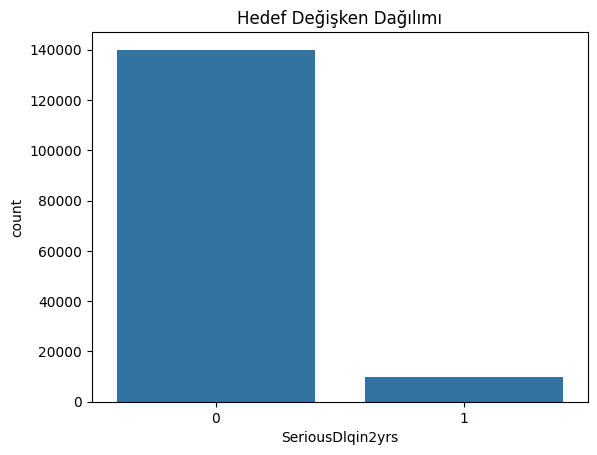

In [6]:
sns.countplot(data=df, x='SeriousDlqin2yrs')
plt.title("Hedef Değişken Dağılımı")
plt.show()

Grafik, veri setinin belirgin şekilde dengesiz olduğunu gösteriyor:
- `0` sınıfı (default olmayanlar) büyük çoğunluğu oluşturuyor (yaklaşık %93)
- `1` sınıfı (default yaşayanlar) toplamın yalnızca küçük bir kısmı (yaklaşık %7)

Kredi riski veri setlerinde bu yapı normaldir; ancak bu durum,
model değerlendirmesinde tek bir metrik yerine daha kapsamlı ölçütler
kullanılması gerektiğini hatırlatıyor.

## 6. Sayısal Değişkenlerin Dağılımları

Bu bölümde temel sayısal değişkenlerin histogramlarına bakıyorum:

- `RevolvingUtilizationOfUnsecuredLines`: Kredi kartı limit kullanım oranı
- `DebtRatio`: Borcun gelire oranı
- `MonthlyIncome`: Aylık gelir
- `NumberOfOpenCreditLinesAndLoans`: Açık kredi/hesap sayısı
- `age`: Müşteri yaşı

Amaç:
- Değişkenlerin hangi aralıklarda yoğunlaştığını görmek,
- Uç değer (outlier) ve sağa çarpık (right-skew) dağılımları tespit etmek,
- İleride uygulanacak log/clip gibi dönüşümler için ön fikir edinmek.


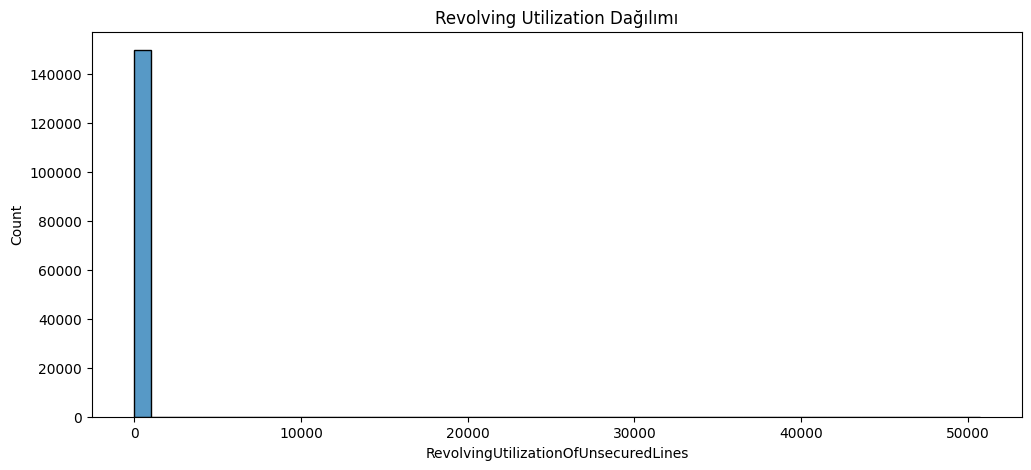

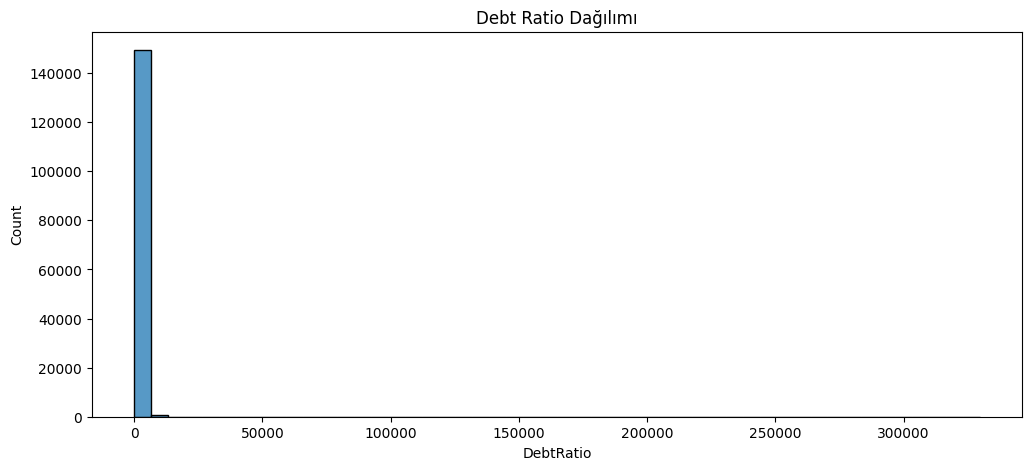

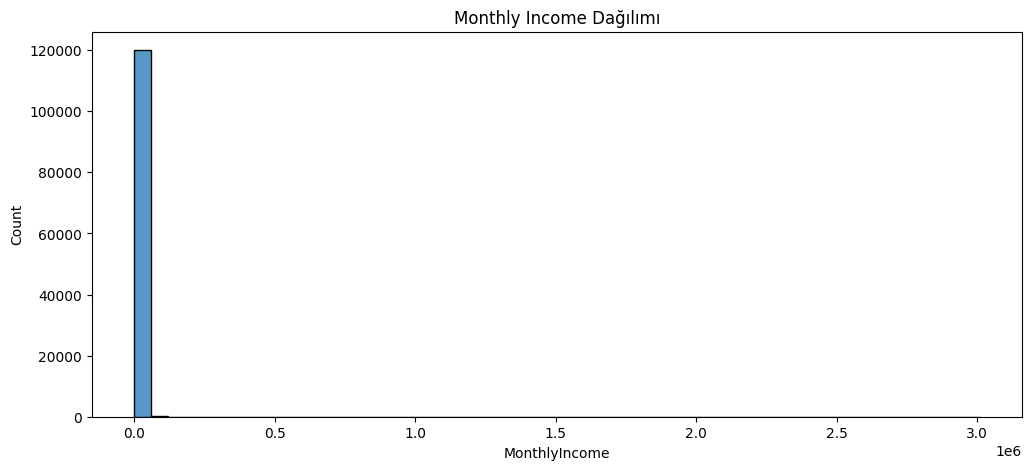

In [7]:
plt.figure(figsize=(12,5))
sns.histplot(df['RevolvingUtilizationOfUnsecuredLines'], bins=50)
plt.title("Revolving Utilization Dağılımı")
plt.show()

plt.figure(figsize=(12,5))
sns.histplot(df['DebtRatio'], bins=50)
plt.title("Debt Ratio Dağılımı")
plt.show()

plt.figure(figsize=(12,5))
sns.histplot(df['MonthlyIncome'], bins=50)
plt.title("Monthly Income Dağılımı")
plt.show()


İlk histogramlar, değişkenlerin çoğunun düşük değer aralıklarında toplandığını ve sağ tarafta uzun kuyruklar olduğunu gösteriyor.  
Özellikle `RevolvingUtilizationOfUnsecuredLines`, `DebtRatio` ve `MonthlyIncome` için birkaç çok büyük uç değer var; bu da normal ölçekte çizildiğinde ana kitlenin sola sıkışmasına ve grafiğin zor okunur hale gelmesine neden oluyor.

### Log-Scale Histogramlar

Bu yüzden bu üç değişken için histogramları log-ölçekte tekrar çizdim; amaç, ana kitlenin dağılımını uç değerlerden daha bağımsız ve okunur bir şekilde görebilmek.


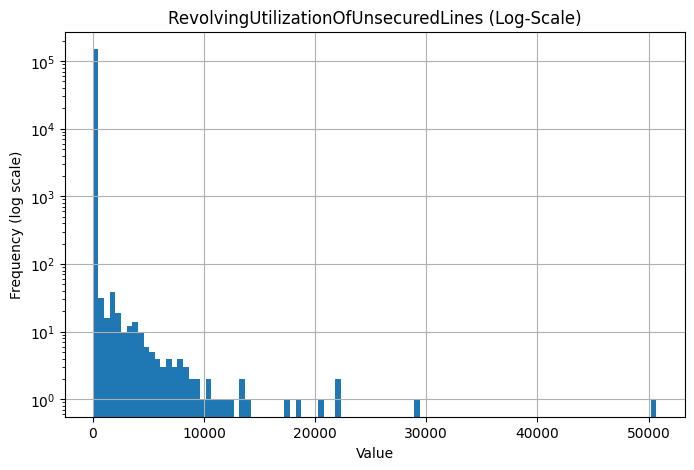

In [8]:
plt.figure(figsize=(8,5))
df['RevolvingUtilizationOfUnsecuredLines'].hist(bins=100, log=True)
plt.title('RevolvingUtilizationOfUnsecuredLines (Log-Scale)')
plt.xlabel('Value')
plt.ylabel('Frequency (log scale)')
plt.show()

 **RevolvingUtilizationOfUnsecuredLines**  
  Gözlemlerin büyük kısmı 0–2 bandında; buna karşılık 50.000 seviyelerine kadar giden birkaç değer var.
  Bu değişken için log-dönüşüm ve üst uçta, örneğin %99.5 persentilde kesmek (winsorize) mantıklı görünüyor.

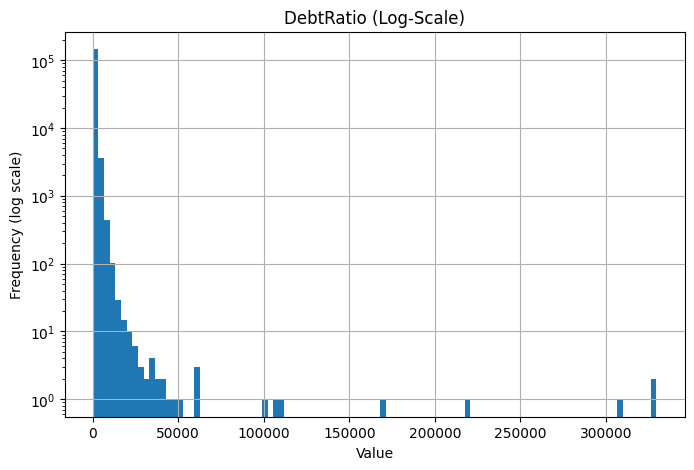

In [9]:
plt.figure(figsize=(8,5))
df['DebtRatio'].hist(bins=100, log=True)
plt.title('DebtRatio (Log-Scale)')
plt.xlabel('Value')
plt.ylabel('Frequency (log scale)')
plt.show()

**DebtRatio**  
  Müşterilerin çoğu 0–2 civarında; 300.000 üzerine kadar çıkan az sayıda gözlem dağılımı bozuyor.  
  Burada da log-dönüşüm + yüksek değerlerde winsorization uygulamak, hem grafiği hem modeli daha okunur/stabil hale getirecek.

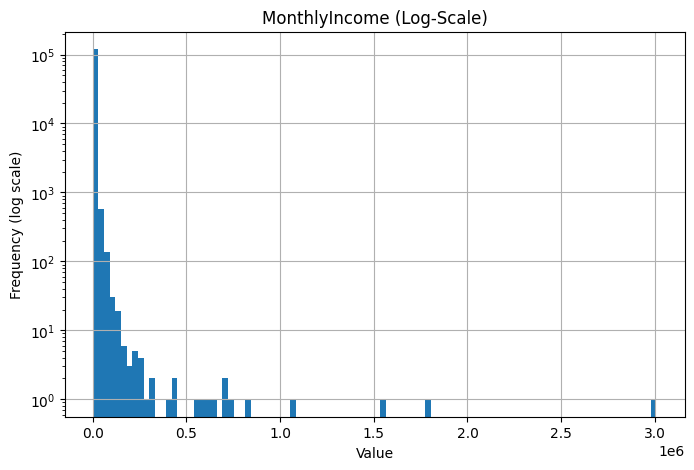

In [10]:
plt.figure(figsize=(8,5))
df['MonthlyIncome'].hist(bins=100, log=True)
plt.title('MonthlyIncome (Log-Scale)')
plt.xlabel('Value')
plt.ylabel('Frequency (log scale)')
plt.show() 

**MonthlyIncome**  
Log-scale dağılım, ana kitlenin 2k–10k bandında toplandığını, bunun dışında 1M+ seviyelerinde birkaç uç değer olduğunu gösteriyor. 
Değişkenin yaklaşık %20’si eksik; FE aşamasında eksikler için ayrı bir `IncomeMissing` flag’i üretmeyi ve çok yüksek gelirleri 
winsorize etmeyi planlıyorum.


## 7. Gecikme Davranışları (Delinquency Analizi)

Bu bölümde gecikme sayısını ölçen üç değişkene bakıyorum:

- `NumberOfTime30-59DaysPastDueNotWorse`
- `NumberOfTime60-89DaysPastDueNotWorse`
- `NumberOfTimes90DaysLate`

Bu kolonlar, müşterinin son yıllarda kaç kez 30–59, 60–89 veya 90+ gün gecikme yaşadığını gösteriyor.  
Kredi verisinde genelde:

- Çoğu müşterinin hiç gecikmesi olmaması (0),
- Daha az sayıda müşteride 1–2 gibi düşük gecikme sayıları,
- Çok küçük bir grupta ise yüksek gecikme sayıları

görmeyi bekleriz.
  
Buradaki amacım, çoğunluğun davranışını görmek ve çok yüksek gecikme değerlerini preprocessing sırasında nasıl ele alacağıma karar vermek (örneğin üst sınır koymak veya ayrı bir flag oluşturmak).


In [11]:
del_cols = [
    'NumberOfTime30-59DaysPastDueNotWorse',
    'NumberOfTime60-89DaysPastDueNotWorse',
    'NumberOfTimes90DaysLate'
]


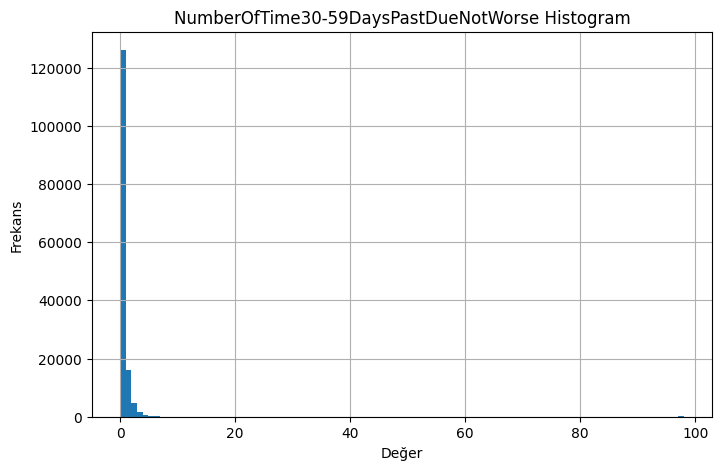

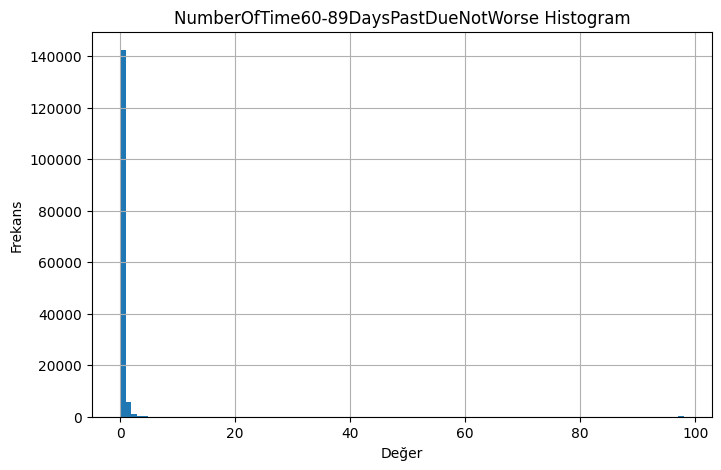

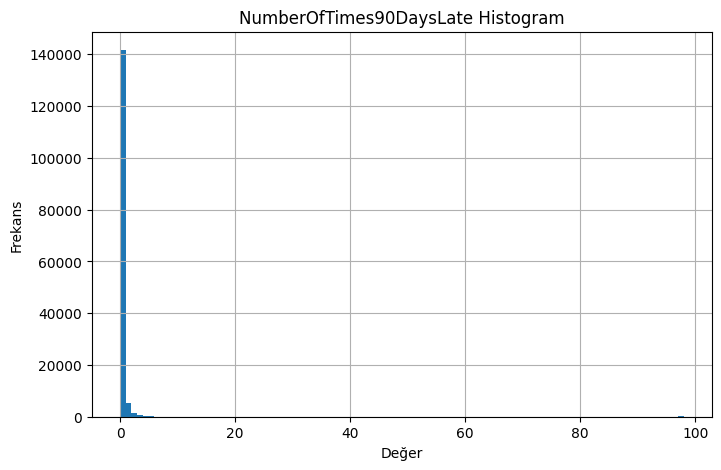

In [12]:
import matplotlib.pyplot as plt

for col in del_cols:
    plt.figure(figsize=(8,5))
    df[col].hist(bins=100)
    plt.title(f"{col} Histogram")
    plt.xlabel("Değer")
    plt.ylabel("Frekans")
    plt.show()



Histogramlar, delinquency değişkenlerinin aşırı sağa çarpık olduğunu gösteriyor:

- Gözlemlerin büyük kısmı 0 değerinde toplanmış.
- Küçük bir grup 1–3 seviyelerinde gecikme yaşıyor.
- Bunun dışında, 98’e kadar çıkan çok yüksek değerler var; bunlar gerçek hayatta pek karşılaşılmayacak kadar uç görünüyor.

Bu yapı, delinquency kolonlarının hem güçlü bir davranışsal risk bilgisi taşıdığını hem de birkaç ekstrem değer yüzünden ham haliyle modele vermenin sağlıklı olmayacağını gösteriyor. Bu yüzden preprocessing aşamasında bu kolonlarda üst sınır (capping/winsorization) ve/veya “çok sık gecikme yaşayan müşteri” şeklinde ek bir flag kullanmayı planlıyorum.



In [13]:
df[del_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
NumberOfTime30-59DaysPastDueNotWorse,150000.0,0.421033,4.192781,0.0,0.0,0.0,0.0,98.0
NumberOfTime60-89DaysPastDueNotWorse,150000.0,0.240387,4.155179,0.0,0.0,0.0,0.0,98.0
NumberOfTimes90DaysLate,150000.0,0.265973,4.169304,0.0,0.0,0.0,0.0,98.0


Describe çıktısı, delinquency değişkenlerinin yapısını daha net gösteriyor. 
25., 50. ve 75. yüzdeliklerin tamamının 0 olması, müşterilerin büyük çoğunluğunun hiç gecikme yaşamamış olduğunu doğruluyor. Buna karşılık maksimum değerin 98 olması, veri setinde çok az sayıda ama oldukça uç gözlem olduğunu gösteriyor.

Burada sadece dağılımı not ediyorum; bu uç değerlerin modele ve riske etkisini 
bir sonraki bölümde hedef değişkenle birlikte değerlendiriyorum.



### Delinquency – Default İlişkisi 

Bu bölümde delinquency değişkenleri ile hedef değişken (`SeriousDlqin2yrs`) arasındaki ilişkiye bakıyorum.  
Beklentim, gecikme sayısı arttıkça default olasılığının da artması ve özellikle 60+ / 90+ gün gecikmelerin risk tarafında daha yoğun görünmesi.

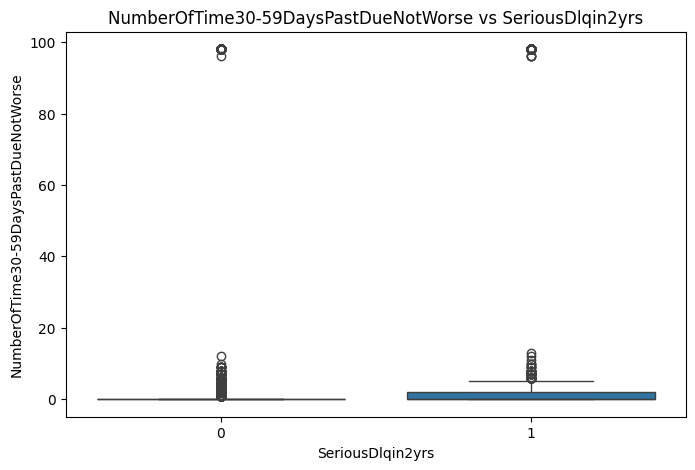

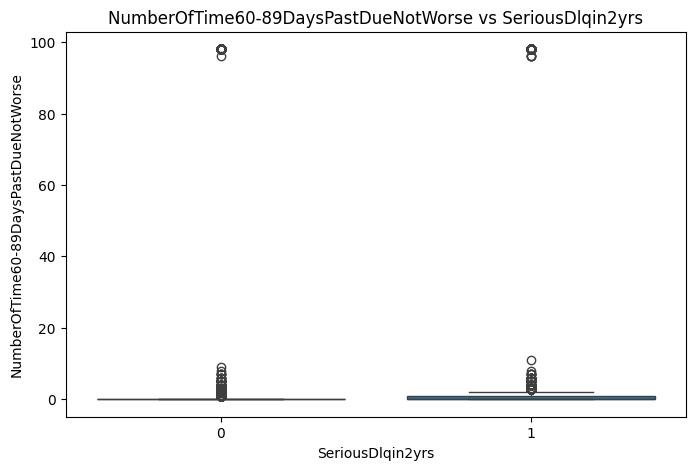

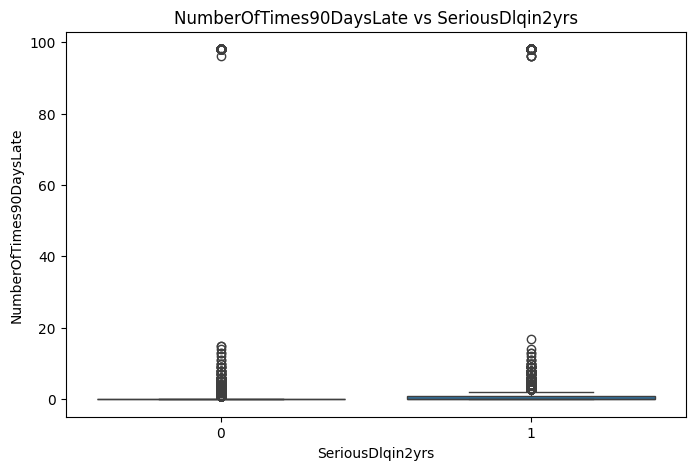

In [14]:
import seaborn as sns

for col in del_cols:
    plt.figure(figsize=(8,5))
    sns.boxplot(data=df, x='SeriousDlqin2yrs', y=col)
    plt.title(f"{col} vs SeriousDlqin2yrs")
    plt.show()


In [15]:
print((df["NumberOfTime30-59DaysPastDueNotWorse"] >= 90).sum())
print((df["NumberOfTime60-89DaysPastDueNotWorse"] >= 90).sum())
print((df["NumberOfTimes90DaysLate"] >= 90).sum())

269
269
269


## Delinquency – Default İlişkisi Yorum

Boxplot’lar, default yaşayan müşterilerde gecikme sayılarının belirgin şekilde daha yüksek olduğunu gösteriyor.  
Her iki sınıfta da çoğunluk sıfır gecikmeye sahip olsa da, gecikmesi olan küçük grup ağırlıklı olarak **default tarafında** toplanıyor. Bu durum, delinquency kolonlarının iş mantığıyla uyumlu olduğunu ve  model için anlamlı bir risk sinyali taşıdığını gösteriyor.

Ek sayımlar, her üç delinquency değişkeninde maksimum değerin 98’e kadar çıktığını ve 90+ gün gecikmeye sahip toplam **269 gözlem** bulunduğunu gösteriyor. Aynı uç değerlerin tekrar etmesi, bunların veri giriş hatası olabileceğini düşündürüyor. Modelin bu uç değerlerden gereksiz etkilenmemesi için FE aşamasında bu gözlemleri belirli bir üst sınırda (capping) toplamak veya ayrı bir kategori/flag ile 
işaretlemeyi planlıyorum.


## 8. MonthlyIncome Analizi ve Eksik Değer İncelemesi

MonthlyIncome değişkeninde yaklaşık %20 oranında eksik değer bulunuyor. 
Eksik gelir bilgisinin default riskiyle ilişkisini incelemek ve`IncomeMissing` flag’inin modele gerçekten katkı sağlayıp sağlamadığını görmek için bu bölümü ayrı ele alıyorum.

In [16]:
df["IncomeMissing"] = df["MonthlyIncome"].isna()
df.groupby("IncomeMissing")["SeriousDlqin2yrs"].mean()


IncomeMissing
False    0.069486
True     0.056137
Name: SeriousDlqin2yrs, dtype: float64

Eksik gelir bilgisine sahip müşterilerin default oranı, geliri bilinen müşterilere kıyaslabiraz daha düşük görünüyor. Bu durum, eksik gelir bilgisinin belirli bir müşteri segmentinde toplandığını ve tek başına “yüksek risk” sinyali vermediğini gösteriyor.

`IncomeMissing` değişkeni modelleme aşamasında yine de bir flag olarak tutulacak;ancak pozitif bir risk göstergesi olarak değil, segment ayrımı yaratabilecek yardımcı bir feature olarak değerlendirilecek.

## 9. Korelasyon Analizi

Bu adımda veri setindeki sayısal değişkenler arasındaki doğrusal ilişkileri incelemek için
korelasyon matrisini ve ısı haritasını oluşturuyorum. Kredi riski veri setlerinde güçlü
korelasyonlar beklenmez; değişkenler genellikle farklı davranış boyutlarını temsil eder.
Isı haritası, bu ilişkilerin görsel olarak daha kolay yorumlanmasını sağlar.


In [17]:
num_cols = df.select_dtypes(include=['int64', 'float64'])
corr = num_cols.corr()

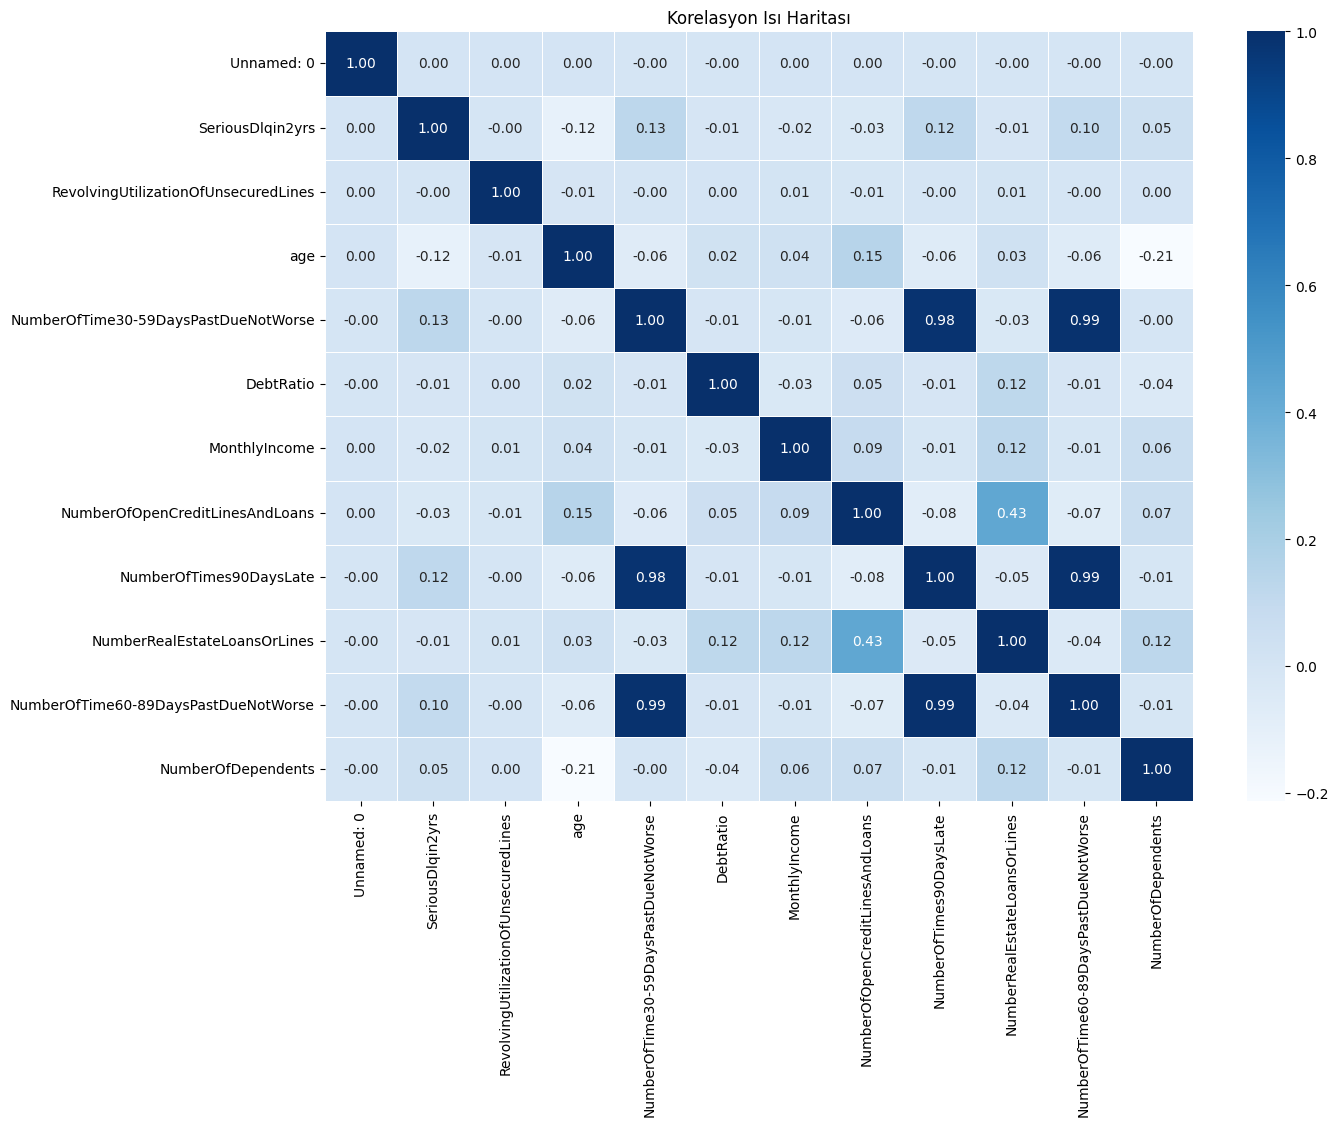

In [18]:
plt.figure(figsize=(14,10))
sns.heatmap(
    corr,
    cmap="Blues",     
    annot=True,      
    fmt=".2f",        
    linewidths=0.5     
)
plt.title("Korelasyon Isı Haritası")
plt.show()


Korelasyon ısı haritası, değişkenlerin birbirleriyle olan doğrusal ilişkisini gösteriyor. 
Grafikte köşegen boyunca yer alan **1.00** değerleri normal; her değişken kendisiyle tam korelasyon içindedir.

Bu veri setinde genel yapı şöyle:

- **Genel korelasyonlar düşük.**  
  Kredi riski verilerinde müşteri davranışı çok boyutlu olduğu için bu beklenen bir durum.

- **Gecikme değişkenleri (30–59, 60–89, 90+ gün) kendi aralarında yüksek korelasyonlu**  
  (≈ 0.98–0.99). Gecikme yaşayan müşterinin birden fazla tipte gecikme yaşaması normal.

- **`SeriousDlqin2yrs` ile korelasyonlar düşük (≈ 0.10 ve altı).**  
 Bu, değişkenlerin işe yaramadığı anlamına gelmiyor; korelasyonu zayıf olsa bile modelin tahmin performansına katkı sağlayabilirler.

- **`NumberOfOpenCreditLinesAndLoans` ile `NumberRealEstateLoansOrLines` arasındaorta düzeyde (≈ 0.43) bir ilişki var.**  
  Portföyü daha geniş müşterilerde bu iki değişkenin birlikte artması beklenebilir.

Özetle, belirgin bir multicollinearity problemi görünmüyor; delinquency değişkenleri ise hem aralarındaki yüksek korelasyon hem de iş mantığı nedeniyle model için güçlü bir sinyal taşımaya devam ediyor.

## 10. Hedef Değişken ile Özelliklerin İlişkisi

Bu bölümde, default olan (1) ve olmayan (0) müşterilerin temel sayısal değişkenlerde nasıl ayrıldığını görmek istiyorum. Özellikle:

- Yaş (`age`)
- Borç oranı (`DebtRatio`)
- Limit kullanımı (`RevolvingUtilizationOfUnsecuredLines`)
- Gelir (`MonthlyIncome`)
- Açık kredi/hat sayısı (`NumberOfOpenCreditLinesAndLoans`)

üzerinden sınıflar arasındaki farklara bakacağım.

Önce bu değişkenler için boxplot çizip iki sınıfın dağılımını karşılaştırıyorum.
Ardından sınıf bazlı ortalama değerlerle bu gözlemleri destekleyip, hangi değişkenlerin riski ayırmada daha faydalı göründüğünü not edeceğim.


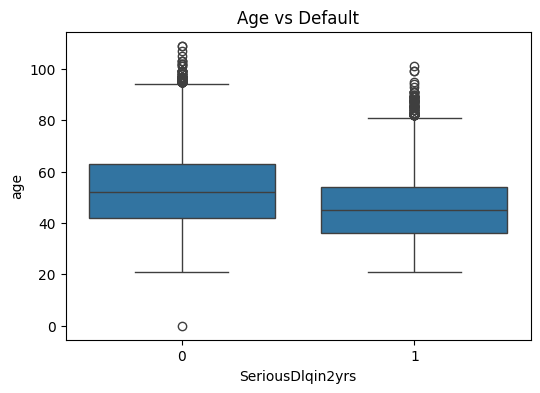

In [19]:
plt.figure(figsize=(6,4))
sns.boxplot(x='SeriousDlqin2yrs', y='age', data=df)
plt.title("Age vs Default")
plt.show()


In [20]:
(df.age == 0).sum()

np.int64(1)

Yaş değişkeninde 1 adet 0 değeri var; bu açıkça hatalı bir kayıt ve median yaş ile doldurulacak.

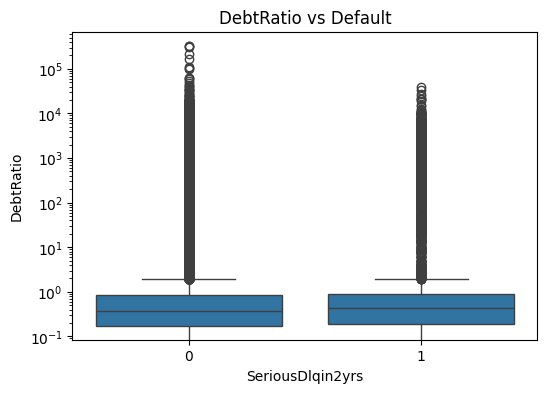

In [21]:
plt.figure(figsize=(6,4))
sns.boxplot(x='SeriousDlqin2yrs', y='DebtRatio', data=df)
plt.yscale("log")  # aşırı uç değerler için log scale daha okunaklı
plt.title("DebtRatio vs Default")
plt.show()


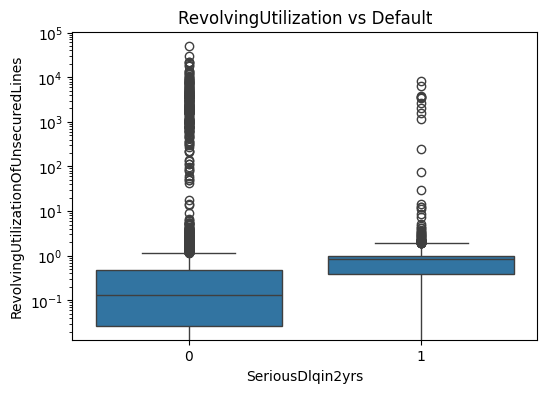

In [22]:
plt.figure(figsize=(6,4))
sns.boxplot(x='SeriousDlqin2yrs', y='RevolvingUtilizationOfUnsecuredLines', data=df)
plt.yscale("log")
plt.title("RevolvingUtilization vs Default")
plt.show()


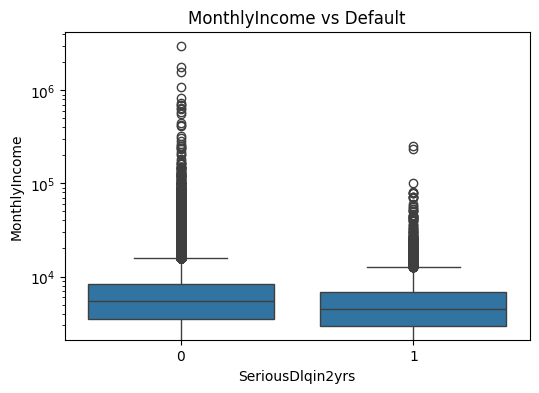

In [23]:
plt.figure(figsize=(6,4))
sns.boxplot(x='SeriousDlqin2yrs', y='MonthlyIncome', data=df)
plt.yscale("log")
plt.title("MonthlyIncome vs Default")
plt.show()



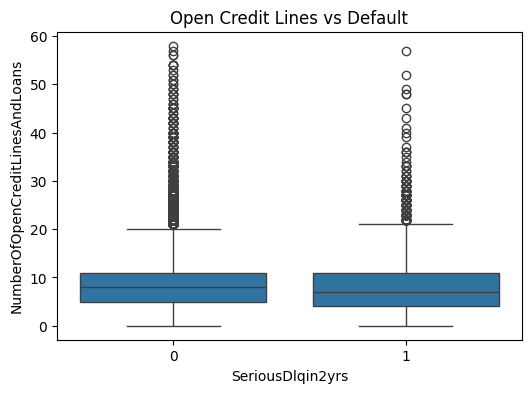

In [24]:
plt.figure(figsize=(6,4))
sns.boxplot(x='SeriousDlqin2yrs', y='NumberOfOpenCreditLinesAndLoans', data=df)
plt.title("Open Credit Lines vs Default")
plt.show()


**Boxplot Yorumları (Sürekli Değişkenler vs Default)**

- **Age**  
  Default olan grupta medyan yaş daha düşük; daha genç müşterilerde risk biraz daha yüksek görünüyor.

- **DebtRatio**  
  Her iki sınıfta da median benzer ve dağılım çok sağa çarpık; çok sayıda aşırı uç var.
  Bu yüzden grafikten net bir sınıf farkı çıkmıyor. DebtRatio’yu log ölçeğe almak ve
  uç değerleri sınırlamak daha uygun olacak.

- **RevolvingUtilizationOfUnsecuredLines**  
  Default sınıfında medyan ve üst çeyrek daha yüksek. Limitini daha agresif kullanan müşterilerde default oranı daha yüksek görünüyor.

- **MonthlyIncome**  
  Default grubunda medyan gelir biraz daha düşük. Düşük gelir bandında risk artıyor; çok yüksek gelir uçları iki sınıfta da var.

- **NumberOfOpenCreditLinesAndLoans (Open Credit Lines)**  
  İki sınıfın medyanları birbirine yakın, dağılımlar benzer. Default sınıfında biraz daha fazla uç değer var ama genel fark zayıf; bu değişken daha çok destekleyici bir bilgi gibi görünüyor.


In [25]:
df.groupby('SeriousDlqin2yrs')[
    ['age',
     'DebtRatio',
     'RevolvingUtilizationOfUnsecuredLines',
     'MonthlyIncome',
     'NumberOfOpenCreditLinesAndLoans']
].mean().T


SeriousDlqin2yrs,0,1
age,52.751375,45.926591
DebtRatio,357.151168,295.121066
RevolvingUtilizationOfUnsecuredLines,6.168855,4.367282
MonthlyIncome,6747.837774,5630.826493
NumberOfOpenCreditLinesAndLoans,8.493620,7.882306


Bu tablo, bir önceki boxplot yorumlarını sayısal olarak özetliyor:

- **Yaş (age)**: Default olmayanlarda ortalama yaş ≈ 53, default olanlarda ≈ 46. Yani default grubunda daha genç bir profil var.

- **MonthlyIncome**: Default olmayanların ortalama geliri ≈ 6750, default olanların ≈ 5600. Default grubunda gelir daha düşük.

- **Open Credit Lines**: Ortalamalar birbirine çok yakın (≈ 8.5 vs 7.9); bu değişken riski ayırmada zayıf bir sinyal veriyor.

- **DebtRatio ve RevolvingUtilization**: Ortalama değerler 0 grubunda daha yüksek görünse de bu sonuç, çarpık dağılım ve uç değerlerden etkileniyor. Bu kolonlarda medyan ve log-ölçekli analizler daha doğru fikir verecek.

Özetle, tablo boxplot’ta gördüğümüz farkları rakamsal olarak doğruluyor; 
ekstra yeni bir karar eklemiyorum.


# **EDA – Genel Değerlendirme**

Bu aşamada *Give Me Some Credit* veri seti, kredi geri ödememe (default) riskiyle ilişkili temel yapıyı anlamak için incelendi. Analiz sonunda hem veri kalitesi
sorunları hem de riski açıklayan temel desenler ortaya çıktı.

### **1. Veri Yapısı ve Eksik Değerler**

Veri seti 150.000 gözlem ve 12 sütundan oluşuyor.

Eksik değerler iki değişkende yoğunlaşıyor:

- **MonthlyIncome (~%20 eksik)**  
- **NumberOfDependents (~%2.6 eksik)**  

Gelir kolonundaki yüksek eksiklik, hem analiz hem modelleme için kritik. Bu yüzden preprocessing aşamasında **medyanla doldurma + `IncomeMissing` flag’i** birlikte
kullanılacak.

### **2. Dağılımlar ve Uç Değerler**

Sayısal değişkenlerin çoğu **sağa çarpık** ve aşırı uç değerler içeriyor. Özellikle:

- **RevolvingUtilizationOfUnsecuredLines**
- **DebtRatio**
- **MonthlyIncome**

için histogramlar ve log-ölçekli grafikler uzun kuyrukları açıkça gösteriyor.
Modelleme öncesinde bu değişkenlerde **log dönüşümü** ve gerekli yerlerde **winsorization / clipping** uygulanacak.

### **3. Hedef Değişken Dağılımı (Class Imbalance)**

Default oranı yaklaşık **%7**; sınıflar belirgin şekilde **dengesiz**.

Bu nedenle:

- Sadece accuracy yeterli olmayacak,  
- ROC-AUC, Recall, Precision, F1 gibi metrikler öne çıkacak,  
- Model eğitiminde class weight / örnekleme stratejileri değerlendirilecek.

### **4. Gecikme (Delinquency) Davranışları**

30–59, 60–89 ve 90+ gün gecikme değişkenleri güçlü davranışsal göstergeler:

- Çoğu müşteri hiç gecikme yaşamamış (değer 0).  
- Maksimum değer **98**; bu, çok az sayıda ama gerçekçi görünmeyen uç gözlemlere işaret ediyor.  
- Default yaşayan müşterilerde gecikme sayıları belirgin şekilde daha yüksek.

Preprocessing aşamasında bu kolonlar hem **uç değer temizliği** alacak hem de **özet değişkenlere** dönüştürülecek (örneğin toplam gecikme skoru, gecikme flag’leri).


### **5. Korelasyon Analizi**

Korelasyonlar genel olarak düşük; bu, kredi davranışlarının çok boyutlu yapısıyla uyumlu.

Dikkat çeken noktalar:

- Üç delinquency değişkeni birbirleriyle yüksek korelasyonlu (≈ 0.98–0.99).  
- Hedef değişkenle korelasyonlar düşük ama yönü tutarlı: gecikme arttıkça default oranı artıyor.  
- `Unnamed: 0` sadece index bilgisi taşıyor; preprocessing aşamasında kaldırılacak.


### **6. Default vs Özellikler**

Default yaşayan müşterilerde:

- **Yaş daha düşük**,  
- **Gelir daha düşük**,  
- **Açık kredi hattı sayısı biraz daha az**,  
- **Delinquency değerleri bariz şekilde daha yüksek**,  
- **Borç/gelir oranı ve limit kullanımı daha oynak**.

Bu tablo, modelde özellikle delinquency, gelir ve limit kullanımı değişkenlerini yakından takip etmek gerektiğini gösteriyor.

# **Genel Sonuç**

EDA sonucunda veri setinin:

- Sınıf dengesizliği olan,  
- Uç değer bakımından zengin,  
- Gelir eksikliği ve gecikme davranışları üzerinden belirgin risk desenleri taşıyan,  
- Kredi risk modellemesi için gerçekçi bir tabular veri seti

olduğu görülüyor.

Bu aşama, sonraki adımlar için temel hazırladı:

- **Data Preprocessing**
  - Eksik değer stratejisi  
  - Outlier yönetimi  
  - Anlamsız kolonların (ör. `Unnamed: 0`) çıkarılması  

- **Feature Engineering**
  - Toplam gecikme skoru ve gecikme flag’leri  
  - Borç yükü oranları  
  - Gelir segmentleri  
  - Davranışsal risk göstergelerinin türetilmesi  

Bu noktada, modelleme aşamasına geçmek için gerekli EDA tamamlanmış durumda.